In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, explained_variance_score
from side_info_decoding.utils import load_data_from_pids
import seaborn as sns

In [2]:
def sliding_window_over_time(data, window_size=10):
    
    if len(data.shape) == 3:
        n_trials, n_units, n_t_bins = data.shape
        data_window = np.zeros((
            n_trials, n_units, n_t_bins - window_size + 1, window_size
        ))
        for t in range(window_size-1, n_t_bins):
            tmp_window = np.zeros((n_trials, n_units, window_size))
            for d in range(window_size):
                  tmp_window[:,:,d] = data[:,:,t - d]
            data_window[:,:,t-window_size] = tmp_window
    else:
        n_trials, n_t_bins = data.shape
        data_window = np.zeros((n_trials, n_t_bins - window_size + 1))
        for t in range(window_size-1, n_t_bins):
            data_window[:,t-window_size] = data[:,t]
    return data_window

#### pupil diameter

In [44]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    '16799c7a-e395-435d-a4c4-a678007e1550',
    '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    '1e176f17-d00f-49bb-87ff-26d237b525f1',
    # '31f3e083-a324-4b88-b0a4-7788ec37b191',
    # "27bac116-ea57-4512-ad35-714a62d259cd",
    "41a3b948-13f4-4be7-90b9-150705d39005",
    "63517fd4-ece1-49eb-9259-371dc30b1dd6",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "7d999a68-0215-4e45-8e6c-879c6ca2b771",
    "8b7c808f-763b-44c8-b273-63c6afbc6aae",
    "9117969a-3f0d-478b-ad75-98263e3bfacf"
]

In [61]:
save_dir = Path("/home/yizi/side_info_decoding/saved_results/lightning_pose_res_bkp/")
# behavior_type = "pupil_diameter"
behavior_type = "wheel_speed"

In [62]:
# pids = [pid for pid in os.listdir(save_dir) if not pid.endswith('.ipynb_checkpoints')]

In [70]:
baseline_metrics, rrr_metrics = [], []
for pid in pids:
    save_path = save_dir/pid/f"{behavior_type}"
    metrics = np.load(save_path/"metrics.npy", allow_pickle=True).item()[pid]
    baseline_metrics.append(metrics["baseline"])
    rrr_metrics.append(metrics["rrr"])
baseline_metrics = np.array(baseline_metrics, dtype=object)
rrr_metrics = np.array(rrr_metrics, dtype=object)

In [64]:
dir_path = Path("/home/yizi/side_info_decoding/saved_results/neural_nets_metrics/")

# behave = "pupil_diameter"
behave = "wheel_speed"
neural_nets = np.ones((len(pids))) * np.nan
for i, roi in enumerate(["all"]):
    for j, pid in enumerate(pids):
        try:
            metrics = np.load(dir_path/behave/pid/f"{roi}.npy", allow_pickle=True)
            neural_nets[j] = metrics[0]
        except:
            pass
neural_nets = np.array(neural_nets)

In [59]:
dir_path = Path("/home/yizi/side_info_decoding/saved_results/lstm_decoder_metrics//")

# behave = "pupil_diameter"
behave = "wheel_speed"
lstm = np.ones((len(pids))) * np.nan
for i, roi in enumerate(["all"]):
    for j, pid in enumerate(pids):
        try:
            metrics = np.load(dir_path/behave/pid/f"{roi}.npy", allow_pickle=True)
            lstm[j] = metrics[0]
        except:
            pass
lstm = np.array(lstm)

In [60]:
plt.rc("figure", dpi=200)
SMALL_SIZE = 10
BIGGER_SIZE = 7
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=.3)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=1)
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.minor.size'] = 3

In [79]:
baseline = np.array([np.mean(x, 0) for x in baseline_metrics])
rrr = np.array([np.mean(x, 0) for x in rrr_metrics])

/tmp/ipykernel_4950/3412785826.py:62: UserWarning: 
The palette list has fewer values (3) than needed (30) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x="value", y="variable", hue='id', data=choice_df, palette=pal, ax=ax1,


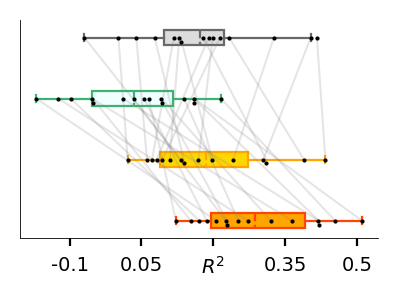

In [81]:
fig, ax1 = plt.subplots(1,1, figsize=(2, 1.5), sharey=True, gridspec_kw={'wspace': 0})
choice_df = pd.DataFrame({
    "baseline": baseline.T[0],
    "nn": neural_nets,
    "lstm": lstm,
    "rrm": rrr.T[0]
})
choice_df = pd.melt(choice_df)

idxs = np.tile(np.arange(choice_df.shape[0]/2), 2)
choice_df['id'] = idxs
pal = sns.color_palette(['grey'], choice_df.shape[1])
my_pal = {"baseline": "white", "nn": "azure", "lstm":"gold", "rrm":"lightsteelblue"}


bplot = sns.boxplot(
    x="value", y="variable", data=choice_df, width=.25, ax=ax1, 
    showmeans=True, meanline=True, palette=my_pal, showfliers=False, 
    boxprops={'color':'k'},
    medianprops={"color": "k", "linewidth": 2, "alpha":.0},
    meanprops={"color": "red", "linewidth": 3},
    orient='h'
)

b1 = ax1.patches[0]
b1.set_edgecolor('dimgrey')
b1.set_facecolor('gainsboro')
b1.set_linewidth(.8)
for q in range(0*6, 0*6+6):
    line = ax1.lines[q]
    line.set_color('dimgrey')
    line.set_linewidth(.8)
    
b2 = ax1.patches[1]
b2.set_edgecolor('mediumseagreen')
b2.set_facecolor('azure')
b2.set_linewidth(.8)
for q in range(1*6, 1*6+6):
    line = ax1.lines[q]
    line.set_color('mediumseagreen')
    line.set_linewidth(.8)

b3 = ax1.patches[2]
b3.set_edgecolor('orange')
b3.set_facecolor('gold')
b3.set_linewidth(.8)
for q in range(2*6, 2*6+6):
    line = ax1.lines[q]
    line.set_color('orange')
    line.set_linewidth(.8)
    
b4 = ax1.patches[3]
b4.set_edgecolor('orangered')
b4.set_facecolor('orange')
b4.set_linewidth(.8)
for q in range(3*6, 3*6+6):
    line = ax1.lines[q]
    line.set_color('orangered')
    line.set_linewidth(.8)

sns.swarmplot(x="value", y="variable", data=choice_df, ax=ax1, size=1.5, color="k")
sns.lineplot(x="value", y="variable", hue='id', data=choice_df, palette=pal, ax=ax1, 
             estimator=None, legend=False, alpha=.2, size=.7)

# ax1.set_ylim(-0.5, 1.5)
ax1.set_xticks([-0.1, 0.05, 0.2, 0.35, 0.5], [-0.1, 0.05, r"$R^2$", 0.35, 0.5])
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_yticks([], [])
ax1.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig("./plots/perf_wheel_speed.png", dpi=200)
# plt.savefig("./plots/perf_pupil_diameter.png", dpi=200)

In [151]:
plt.rc("axes", linewidth=1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3))
ax1.boxplot(
    np.c_[baseline_metrics.mean(1)[:,0], rrr_metrics.mean(1)[:,0]], 
    showmeans=True, 
    vert=True, patch_artist=False, labels=["ridge\n regression", "reduced rank\n model"],
    meanprops={'marker':'_',
               'markerfacecolor':'white', 
               'markeredgecolor':'b',
               'markersize':'10'},
)
ax1.set_yticks([0, 0.2, 0.4], [0, r"$R^2$", 0.4], fontsize=12)
ax1.set_title("35% relative increase", fontsize=12)

ax2.scatter(baseline_metrics.mean(1)[:,0], rrr_metrics.mean(1)[:,0], c="blue", s=30)
ax2.set_xlim(-0.15, 0.6)
ax2.set_ylim(-0.15, 0.6)
ax2.set_xlabel("R2 (Lightning Pose Causal Decoder)", fontsize=12)
ax2.set_ylabel("R2 (Reduced Rank Causal Decoder)", fontsize=12)
ax2.plot([-0.15, 0.6], [-0.15, 0.6], ls="--", c=".3")
ax2.set_title(f"Pupil Diameter: {len(pids)} Sessions")

plt.tight_layout()
# plt.savefig("./plots/pupil_boxplot.png", dpi = 200)

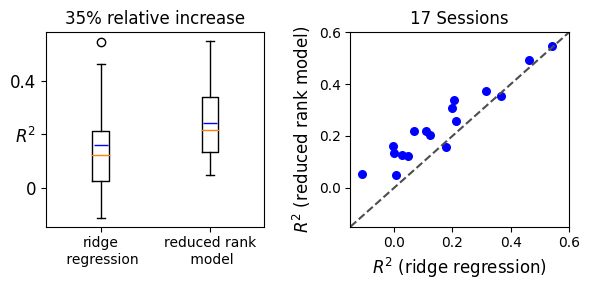

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,3))
ax1.boxplot(
    np.c_[baseline_metrics.mean(1)[:,0], rrr_metrics.mean(1)[:,0]], 
    showmeans=True, 
    vert=True, patch_artist=False, labels=["ridge\n regression", "reduced rank\n model"],
    meanprops={'marker':'_',
               'markerfacecolor':'white', 
               'markeredgecolor':'b',
               'markersize':'10'},
)
ax1.set_yticks([0, 0.2, 0.4], [0, r"$R^2$", 0.4], fontsize=12)
ax1.set_title("35% relative increase", fontsize=12)

ax2.scatter(baseline_metrics.mean(1)[:,0], rrr_metrics.mean(1)[:,0], c="blue", s=30)
ax2.set_xlim(-0.15, 0.6)
ax2.set_ylim(-0.15, 0.6)
ax2.set_xlabel(r"$R^2$ (ridge regression)", fontsize=12)
ax2.set_ylabel(r"$R^2$ (reduced rank model)", fontsize=12)
ax2.plot([-0.15, 0.6], [-0.15, 0.6], ls="--", c=".3")
ax2.set_title(f"{len(pids)} Sessions")

plt.tight_layout()
# plt.savefig("./plots/pupil_scatters.png", dpi = 200)

In [109]:
behavior_type = "pupil_diameter"
# behavior_type = "wheel_speed"

In [128]:
pid = pids[0]
# pids = [pid]
save_path = save_dir/pid/f"{behavior_type}"
traces = np.load(save_path/"traces.npy", allow_pickle=True).item()[pid]
baseline_traces = traces["baseline"]
rrr_traces = traces["rrr"]

In [111]:
obs_traces = {}
pids_ = [pid]
for pid in pids_:
    
    obs_traces[pid] = []
    
    X_dict, Y_dict = load_data_from_pids(
        [pid],
        brain_region="all",
        behavior=behavior_type,
        data_type="all_ks",
        n_t_bins = 60,
        align_time_type="feedback_times",
        t_before=0.2,
        t_after=1.0,
        normalize_input=False
    )
    
    X, Y = X_dict[pid], Y_dict[pid]
    offset = Y.max()
    Y /= offset
    window_Y = sliding_window_over_time(Y, window_size=11)
    
    xval_traces = []
    kf = KFold(n_splits=5, shuffle=True, random_state=666)
    for train, test in kf.split(X, Y):
        xval_traces.append(window_Y[test])
        
    obs_traces[pid].append(xval_traces)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367
found 367 trials from 17.86 to 2310.69 sec.


Compute spike count: 100%|███████████████████| 367/367 [00:02<00:00, 159.12it/s]


In [ ]:
obs_traces[pid] = np.concatenate(np.concatenate(obs_traces[pid]))

In [ ]:
rrr_traces[3].shape
#0: 6,12,29,57,69; 1:0,10,14,21,29,38

In [101]:
# Using Unicode superscript characters
text = "R²"

print(text)


R²


In [ ]:
fig, axes = plt.subplots(1,5,figsize=(10,2))

# chosen_trails = [10,14,21,29,42] #6,12,29,57,69
chosen_trails = [6,12,29,57,69]
for i, idx in enumerate(chosen_trails):
    
    axes[i].plot(baseline_traces[0][idx].flatten(), c="royalblue", linewidth=1., label="ridge regression")
    axes[i].plot(rrr_traces[0][idx].flatten(), c="darkorange", linewidth=1.5, label="reduced rank model")
    axes[i].plot(obs_traces[pid][idx].flatten(), c="dimgrey", linewidth=1., label="pupil diameter")
    axes[i].set_ylim([0.6,0.8])
    
    if i == 0:
        # axes[i].set_yticks([0.4, 0.55, 0.7, 0.85, 1.0], [0.4, 0.55, "AUC", 0.85, 1.0], fontsize=10)
        # axes[i].set_yticks([0.6, 0.7, 0.8], [0.6, 0.7, 0.8], fontsize=10)
        axes[i].spines[['right', 'top']].set_visible(False)
    else:
        axes[i].spines[['right', 'top', 'left']].set_visible(False)
        axes[i].set_yticks([], [])
    axes[i].set_ylabel("")
    axes[i].tick_params('both', length=2, width=1, which='major')
    axes[i].tick_params('both', length=2, width=1, which='minor')
        
    axes[i].set_xticks([0, 25, 50], [0, "time (s)",1.2])
    # axes[i].legend(bbox_to_anchor=(1.05,1.5), ncol=3, frameon=False)
    
# ax.set_title("pupil diameter")
plt.tight_layout()
# plt.savefig("./figures/wheel_traces.png", dpi = 400)

In [163]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    '0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a',
    '143dd7cf-6a47-47a1-906d-927ad7fe9117',
    '16799c7a-e395-435d-a4c4-a678007e1550',
    '1a60a6e1-da99-4d4e-a734-39b1d4544fad',
    '1e176f17-d00f-49bb-87ff-26d237b525f1',
    '31f3e083-a324-4b88-b0a4-7788ec37b191',
    "27bac116-ea57-4512-ad35-714a62d259cd",
    "41a3b948-13f4-4be7-90b9-150705d39005",
    "63517fd4-ece1-49eb-9259-371dc30b1dd6",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "7d999a68-0215-4e45-8e6c-879c6ca2b771",
    "8b7c808f-763b-44c8-b273-63c6afbc6aae",
    "9117969a-3f0d-478b-ad75-98263e3bfacf"
]

In [164]:
save_dir = Path("/home/yizi/side_info_decoding/saved_results/lightning_pose_res_bkp/")
behavior_type = "paw_speed"

In [165]:
baseline_metrics, rrr_metrics = [], []
for pid in pids:
    save_path = save_dir/pid/f"{behavior_type}"
    metrics = np.load(save_path/"metrics.npy", allow_pickle=True).item()[pid]
    baseline_metrics.append(metrics["baseline"])
    rrr_metrics.append(metrics["rrr"])
baseline_metrics = np.array(baseline_metrics)
rrr_metrics = np.array(rrr_metrics)

In [152]:
print(baseline_metrics.mean((0,1))[0])
print(rrr_metrics.mean((0,1))[0])

-0.12431640231277413
0.004293101585630106


In [153]:
print((0.004293101585630106 - -0.12431640231277413)/-0.12431640231277413)

-1.0345336697793817


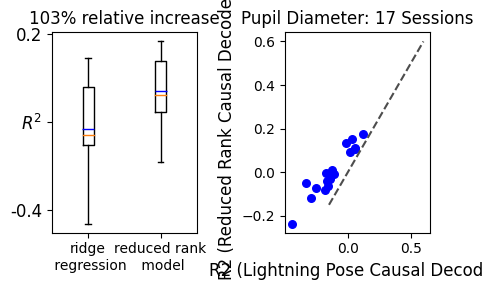

In [154]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(4.5,3))
ax1.boxplot(
    np.c_[baseline_metrics.mean(1)[:,0], rrr_metrics.mean(1)[:,0]], 
    showmeans=True, 
    vert=True, patch_artist=False, labels=["ridge\n regression", "reduced rank\n model"],
    meanprops={'marker':'_',
               'markerfacecolor':'white', 
               'markeredgecolor':'b',
               'markersize':'9'},
)
ax1.set_yticks([-0.4, -0.1, 0.2], [-0.4, r"$R^2$", 0.2], fontsize=12)
ax1.set_title("103% relative increase", fontsize=12)

ax2.scatter(baseline_metrics.mean(1)[:,0], rrr_metrics.mean(1)[:,0], c="blue", s=30)
# ax2.set_xlim(-0.15, 0.6)
# ax2.set_ylim(-0.15, 0.6)
ax2.set_xlabel("R2 (Lightning Pose Causal Decoder)", fontsize=12)
ax2.set_ylabel("R2 (Reduced Rank Causal Decoder)", fontsize=12)
ax2.plot([-0.15, 0.6], [-0.15, 0.6], ls="--", c=".3")
ax2.set_title(f"Pupil Diameter: {len(pids)} Sessions")

plt.tight_layout()
plt.savefig("./plots/paw_boxplot.png", dpi = 200)

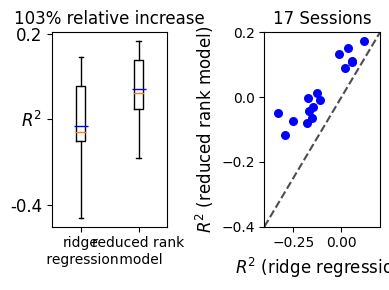

In [184]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(4,3))
ax1.boxplot(
    np.c_[baseline_metrics.mean(1)[:,0], rrr_metrics.mean(1)[:,0]], 
    showmeans=True, 
    vert=True, patch_artist=False, labels=["ridge\n regression", "reduced rank\n model"],
    meanprops={'marker':'_',
               'markerfacecolor':'white', 
               'markeredgecolor':'b',
               'markersize':'10'},
)
ax1.set_yticks([-0.4, -0.1, 0.2], [-0.4, r"$R^2$", 0.2], fontsize=12)
ax1.set_title("103% relative increase", fontsize=12)

ax2.scatter(baseline_metrics.mean(1)[:,0], rrr_metrics.mean(1)[:,0], c="blue", s=30)
ax2.set_xlim([-0.4, 0.2])
ax2.set_ylim([-0.4, 0.2])
ax2.set_xlabel(r"$R^2$ (ridge regression)", fontsize=12)
ax2.set_ylabel(r"$R^2$ (reduced rank model)", fontsize=12)
ax2.plot([-0.4, 0.2], [-0.4, 0.2], ls="--", c=".3")
ax2.set_title(f"{len(pids)} Sessions")

plt.tight_layout()
plt.savefig("./plots/paw_scatters.png", dpi = 200)

In [173]:
from sklearn.preprocessing import normalize

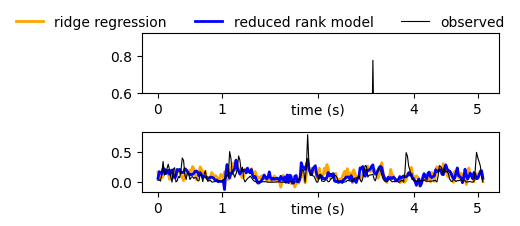

In [188]:
fig, axes = plt.subplots(2,1,figsize=(5,2.5))
for i, ax in enumerate(axes):
    i = i + 1
    ax.plot(normalize(baseline_traces[-1][i:i+5]).flatten(), c="orange", linewidth=2, label="ridge regression")
    ax.plot(normalize(rrr_traces[-1][i:i+5]).flatten(), c="b", linewidth=2, label="reduced rank model")
    ax.plot(normalize(obs_traces[-1][i:i+5]).flatten(), c="k", linewidth=.8, label="observed")
    ax.set_xticks([0, 50, 125, 200, 250], [0, 1, "time (s)", 4, 5])
    if i == 1:
        ax.legend(bbox_to_anchor=(1.05,1.5), ncol=3, frameon=False)
        ax.set_ylim(0.6, .925)
plt.tight_layout()
# plt.savefig("./plots/paw_traces.png", dpi = 400)

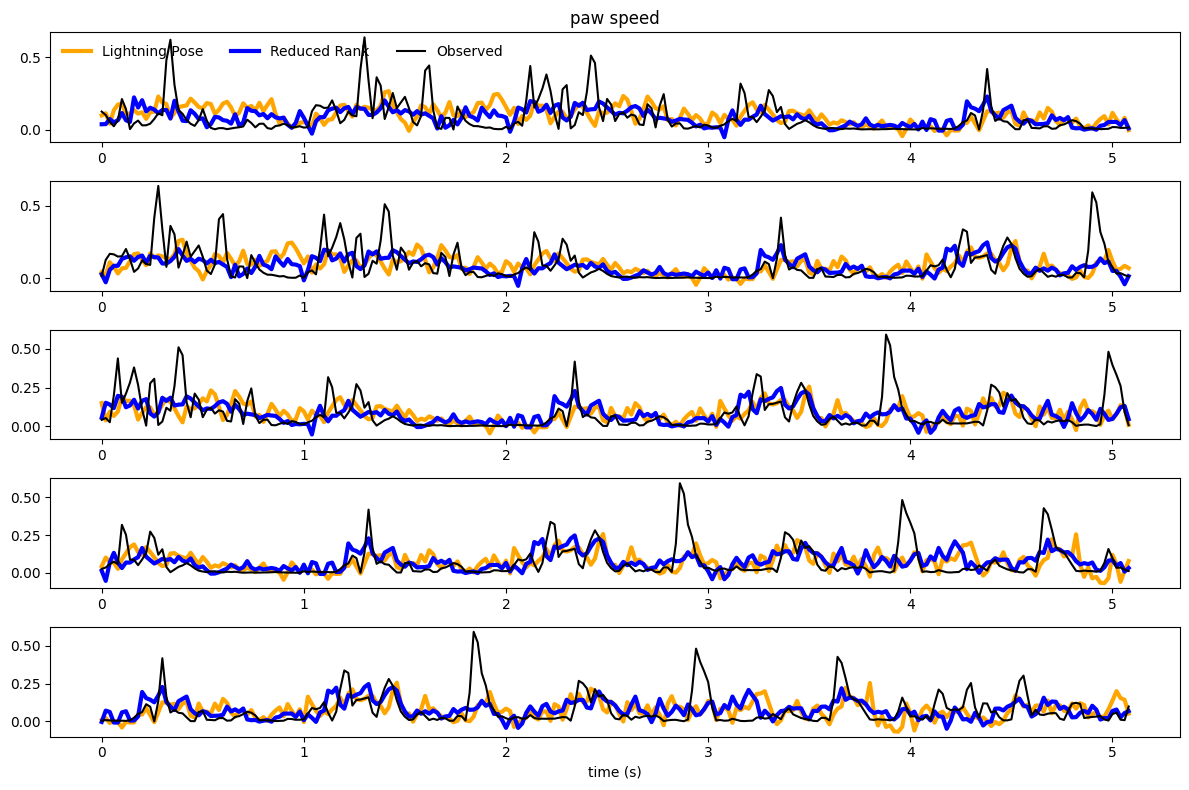

In [167]:
fig, axes = plt.subplots(5,1,figsize=(12,8))
for i, ax in enumerate(axes):
    ax.plot(baseline_traces[-1][i:i+5].flatten(), c="orange", linewidth=3, label="Lightning Pose")
    ax.plot(rrr_traces[-1][i:i+5].flatten(), c="b", linewidth=3, label="Reduced Rank")
    ax.plot(obs_traces[-1][i:i+5].flatten(), c="k", label="Observed")
    ax.set_xticks([0, 50, 100, 150, 200, 250], [0, 1, 2, 3, 4, 5])
    if i == 0:
        ax.set_title("paw speed")
        ax.legend(loc="upper left", ncol=3, frameon=False)
        # ax.set_ylim(0.6, .925)
ax.set_xlabel("time (s)")
plt.tight_layout()
# plt.savefig("/home/yizi/side_info_decoding/saved_plots/lightning_pose_traces.png",
#             dpi = 400)

compare to good units

In [6]:
import os
pids = []
for fname in os.listdir("/home/yizi/side_info_decoding/saved_results/lightning_pose_res/"):
    if not fname.endswith(".ipynb_checkpoints"):
        pids.append(fname)

In [9]:
save_dir = Path("/home/yizi/side_info_decoding/saved_results/lightning_pose_res/")
behavior_type = "pupil_diameter"

In [10]:
baseline_metrics, rrr_metrics = [], []
for pid in pids:
    save_path = save_dir/pid/f"{behavior_type}"
    metrics = np.load(save_path/"metrics.npy", allow_pickle=True).item()[pid]
    baseline_metrics.append(metrics["baseline"])
    rrr_metrics.append(metrics["rrr"])
baseline_metrics = np.array(baseline_metrics)
rrr_metrics = np.array(rrr_metrics)

In [11]:
print(baseline_metrics.mean((0,1))[0])
print(rrr_metrics.mean((0,1))[0])

0.1877975294947174
0.21005010383687098


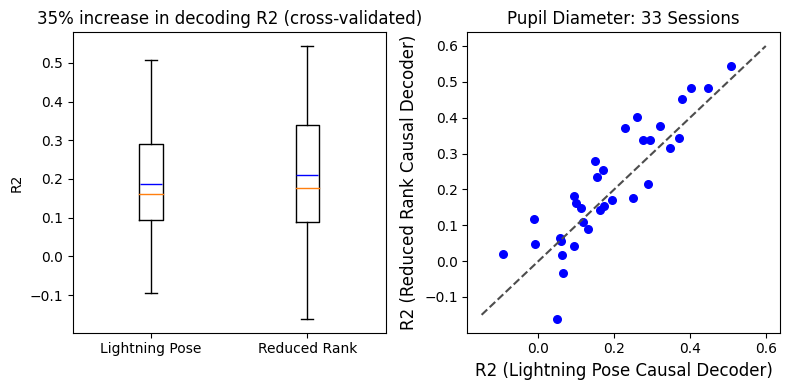

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.boxplot(
    np.c_[baseline_metrics.mean(1)[:,0], rrr_metrics.mean(1)[:,0]], 
    showmeans=True, 
    vert=True, patch_artist=False, labels=["Lightning Pose", "Reduced Rank"],
    meanprops={'marker':'_',
               'markerfacecolor':'white', 
               'markeredgecolor':'b',
               'markersize':'16'},
)
ax1.set_ylabel("R2")
ax1.set_title("35% increase in decoding R2 (cross-validated)")

ax2.scatter(baseline_metrics.mean(1)[:,0], rrr_metrics.mean(1)[:,0], c="blue", s=30)
# ax2.set_xlim(-0.15, 0.6)
# ax2.set_ylim(-0.15, 0.6)
ax2.set_xlabel("R2 (Lightning Pose Causal Decoder)", fontsize=12)
ax2.set_ylabel("R2 (Reduced Rank Causal Decoder)", fontsize=12)
ax2.plot([-0.15, 0.6], [-0.15, 0.6], ls="--", c=".3")
ax2.set_title(f"Pupil Diameter: {len(pids)} Sessions")

plt.tight_layout()
# plt.savefig("/home/yizi/side_info_decoding/saved_plots/lightning_pose_perf.png",
#             dpi = 400)